## Task

You are required to do text classification using different methods.

We will use the 20 news group dataset from sklearn. It has news articles from 20 different categories and the goal is to classify a given article to a category. In this notebook, you are required to work with only 5 categories.

You are required to the following things.
1. Preprocess the data in any way you feel suitable (change case, remove stopwords, punctuation, stemming, lemmatization, etc.)
2. Make a [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) matrix for train and test data. Set `max_features=5000` so that we don't use all the vocabulary.
3. Fit a [NaiveBayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) model on TF-IDF train data and evaluate on test data.
4. Make a Neural Network with 2 linear layers and train it on TF-IDF train data and evaluate on test data.
5. Tokenize the data.
6. Make and train a Neural Network with RNN on tokenized train data and evaluate on test data.
7. Make and train a Neural Network with GRU on tokenized train data and evaluate on test data.
8. Make and train a Neural Network with LSTM on tokenized train data and evaluate on test data.
9. Lastly, report the performance of each model by using confusion matrices.

In [2]:
from IPython.display import clear_output
from sklearn.datasets import fetch_20newsgroups
import spacy
import nltk
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
nltk.download('punkt')

clear_output()

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 'rec.autos']

In [4]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

In [5]:
train_data_x = newsgroups_train.data
train_data_y = newsgroups_train.target
test_data_x = newsgroups_test.data
test_data_y = newsgroups_test.target

len(train_data_x), len(train_data_y), len(test_data_x), len(test_data_y)

(2628, 2628, 1749, 1749)

### 1- Preprocess the data

In [6]:
## exploring the data a bit
print(train_data_x[0])
print(train_data_y[0])


  Nut or not, he was clearly a liar.  He said he would surrender after
  local radio stations broadcast his message, but he didn't.  Then he
  said he would surrender after Passover, but he didn't.

  None of which excuses the gross incompetence and disregard for the
  safety of the children displayed by the feds.   As someone else
  pointed out, if it had been Chelsea Clinton in there you would 
  probably have seen more restraint.

4


In [7]:
# I'll define some functions here to use later for preprocessing
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm')
def remove_newlines(text):
  return text.replace('\n', ' ')

def remove_punctuation(text):
  doc = nlp(text)
  return ' '.join([token.text for token in doc if not token.is_punct])

def remove_stopwords(text):
  doc = nlp(text)
  return ' '.join([token.text for token in doc if not token.is_stop])

def lemmatize(text):
  doc = nlp(text)
  return ' '.join([token.lemma_ for token in doc])

def preprocess(text):
  text = lemmatize(text)
  text = remove_punctuation(text)
  text = remove_stopwords(text)
  text = text.lower()
  text = text.strip()
  text = text.replace('\n', ' ')
  return text

# this is kinda slow, so I am defining a function that avoids unnecssary loops
def preprocess_fast(text):
  doc = nlp(text)
  text = ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
  text = text.lower()
  text = text.strip()
  text = text.replace('\n', ' ')
  return text

# testing these functions
test_statment = "I'm Adnan and I am doing something or maybe not"
print(remove_punctuation(test_statment))
print(remove_stopwords(test_statment))
print(lemmatize(test_statment)) # I will do lemmatization first since some words will be affected when I remove punctuation (I'm -> be but Im !-> be), though "be" will be removed since it's a stopword.
print(preprocess(test_statment))
print(preprocess_fast(test_statment))

I 'm Adnan and I am doing something or maybe not
Adnan maybe
I be Adnan and I be do something or maybe not
adnan maybe
adnan maybe


In [8]:
processed_X_train = [preprocess_fast(text) for text in train_data_x]
processed_X_test = [preprocess_fast(text) for text in test_data_x]
X_train = processed_X_train.copy()
X_test = processed_X_test.copy()
y_train = train_data_y
y_test = test_data_y

In [9]:
X_train[0]

'nut clearly liar   say surrender     local radio station broadcast message       say surrender passover      excuse gross incompetence disregard     safety child display feds        point chelsea clinton     probably see restraint'

### 2- TF-IDF
Set max_features=5000 so that we don't use all the vocabulary.

In [10]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### 3- NaiveBayes
Fit a NaiveBayes model on TF-IDF train data and evaluate on test data.

In [11]:
NaiveBayesModel = MultinomialNB()
NaiveBayesModel.fit(X_train, y_train)
preds = NaiveBayesModel.predict(X_test)
NaiveBayesModel_accuracy = accuracy_score(y_test, preds)
NaiveBayesModel_cm = confusion_matrix(y_test, preds)
print(f"Accuracy on test data: {NaiveBayesModel_accuracy * 100:.2f}%")
print("Confusion Matrix: ")
print(NaiveBayesModel_cm)

Accuracy on test data: 77.02%
Confusion Matrix: 
[[218  10  33  32  26]
 [  4 351  21  13   0]
 [  7   9 368  12   0]
 [ 20  23  33 318   0]
 [105  12  29  13  92]]


In [12]:
print("Sample: ")
print(test_data_x[0])
print("Predicted: ", preds[0])
print("Actual: ", y_test[0])
print("Category", categories[preds[0]])

Sample: 
I just wanted to point out, that Teflon wasn't from the space program.
It was from the WWII nuclear weapons development program.  Pipes in the 
system for fractioning and enriching uranium had to be lined with it.

Uranium Hexafloride was the chemical they turned the pitchblend into for
enrichment.  It is massively corrosive.  Even to Stainless steels. Hence
the need for a very inert substaance to line the pipes with.  Teflon has
all its molecular sockets bound up already, so it is very unreactive.

My 2 sense worth.
Predicted:  3
Actual:  3
Category sci.space


### 4- Neural Network with 2 linear layers
Make a Neural Network with 2 linear layers and train it on TF-IDF train data and evaluate on test data.

In [13]:
type(X_train[0])

scipy.sparse._csr.csr_matrix

In [14]:
X_train[0].toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [15]:
X_train_tensors = []
X_test_tensors = []
for entry in X_train:
  X_train_tensors.append(torch.tensor(entry.toarray()).to(torch.float32))

for entry in X_test:
  X_test_tensors.append(torch.tensor(entry.toarray()).to(torch.float32))

# X_test_tensors[0]
custom_train_dataset = torch.utils.data.TensorDataset(torch.stack(X_train_tensors), torch.tensor(y_train).long())
custom_test_dataset = torch.utils.data.TensorDataset(torch.stack(X_test_tensors), torch.tensor(y_test).long())
train_dataloader = DataLoader(custom_train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(custom_test_dataset, batch_size=64, shuffle=True)


In [16]:
train_dataloader.dataset[0]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor(4))

In [17]:
class NNClassifier(nn.Module):
  def __init__(self):
    super(NNClassifier, self).__init__()
    self.layer1 = nn.Linear(5000, 2500)
    self.layer2 = nn.Linear(2500, 5)
    self.leaky_relu = nn.LeakyReLU()

  def forward(self, x):
    x = x.squeeze(1)  # Remove the extra dimension
    x = self.layer1(x)
    x = self.leaky_relu(x)
    x = self.layer2(x)
    return x

In [18]:
## sanity check
NN_model = NNClassifier()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

NN_model.to(device)
NN_model.eval()
output = NN_model(train_dataloader.dataset[0][0].to(device))
output.shape


torch.Size([1, 5])

In [19]:
# prepare training
%%time
num_epochs = 10
lr = 1e-3
optimizer = torch.optim.Adam(NN_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# training loop
train_losses = []

for i in range(num_epochs):

  epoch_weighted_loss = 0
  # train loop
  NN_model.train()
  for batch_X, batch_y in train_dataloader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    outputs = NN_model(batch_X)
    loss = criterion(outputs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    epoch_weighted_loss += (len(batch_y) * loss.item())


  epoch_loss = epoch_weighted_loss/len(train_dataloader.dataset)
  train_losses.append(epoch_loss)
  # we don't have validation loop in this case

  print(f'epoch {i+1}/{num_epochs}, training loss = {epoch_loss}')



epoch 1/10, training loss = 1.121656015946259
epoch 2/10, training loss = 0.31249667951324034
epoch 3/10, training loss = 0.1406781896154993
epoch 4/10, training loss = 0.0938537293645345
epoch 5/10, training loss = 0.07881352685596028
epoch 6/10, training loss = 0.07045988461833384
epoch 7/10, training loss = 0.07244209079723947
epoch 8/10, training loss = 0.06623370749408115
epoch 9/10, training loss = 0.06620900394519737
epoch 10/10, training loss = 0.0650584778776449
CPU times: user 3.34 s, sys: 195 ms, total: 3.54 s
Wall time: 4.16 s


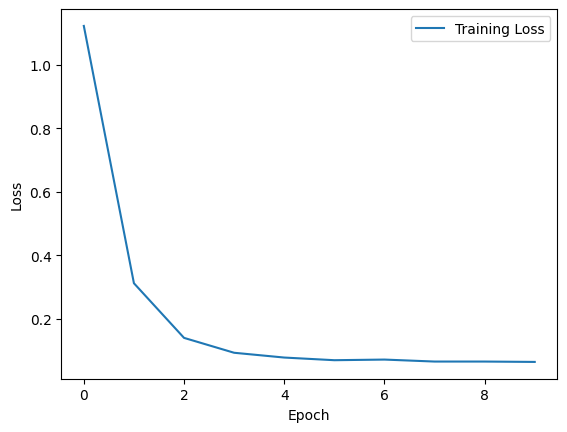

In [20]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# evaluating on test set
NN_model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        outputs = NN_model(batch_X)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

NN_Model_accuracy = accuracy_score(all_labels, all_preds)
NN_Model_cm = confusion_matrix(all_labels, all_preds)
print(f"Accuracy on test data: {NN_Model_accuracy * 100:.2f}%")
print("Confusion Matrix: ")
print(NN_Model_cm)

Accuracy on test data: 77.19%
Confusion Matrix: 
[[191   7  21  23  77]
 [  6 339  23  17   4]
 [ 14   7 357  11   7]
 [ 23  17  31 318   5]
 [ 64   8  22  12 145]]


### 5- Tokenize the data.

In [22]:
tokenized_train_data = [word_tokenize(text.lower()) for text in tqdm(processed_X_train, desc='Tokenizing data')]
tokenized_test_data = [word_tokenize(text.lower()) for text in tqdm(processed_X_test, desc='Tokenizing data')]

Tokenizing data: 100%|██████████| 1749/1749 [00:00<00:00, 2197.72it/s]


In [23]:
print(tokenized_train_data[0])
print(tokenized_test_data[0])

['nut', 'clearly', 'liar', 'say', 'surrender', 'local', 'radio', 'station', 'broadcast', 'message', 'say', 'surrender', 'passover', 'excuse', 'gross', 'incompetence', 'disregard', 'safety', 'child', 'display', 'feds', 'point', 'chelsea', 'clinton', 'probably', 'see', 'restraint']
['want', 'point', 'teflon', 'space', 'program', 'wwii', 'nuclear', 'weapon', 'development', 'program', 'pipes', 'system', 'fraction', 'enrich', 'uranium', 'line', 'uranium', 'hexafloride', 'chemical', 'turn', 'pitchblend', 'enrichment', 'massively', 'corrosive', 'stainless', 'steel', 'need', 'inert', 'substaance', 'line', 'pipe', 'teflon', 'molecular', 'socket', 'bind', 'unreactive', '2', 'sense', 'worth']


In [24]:
# model = Word2Vec(tokenized_train_data, vector_size=128, window=5, min_count=1, workers=4)
# word_vectors = model.wv

In [25]:
# vocab_size = len(word_vectors.key_to_index)
# vocab_size

In [26]:
class ConstructVocab():
    def __init__(self, news):
        self.news = news
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()

    def create_index(self):
        for s in self.news:
            self.vocab.update(s)

        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0

        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token

        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word
constructed_vocab = ConstructVocab(tokenized_train_data + tokenized_test_data)

In [27]:
print(constructed_vocab.word2idx['<pad>'])
print(constructed_vocab.vocab[10:20])

0
['%', '&', "'", "''", "'-i", "'89", "'93", "'bout", "'cause", "'cos"]


In [28]:
# max_len = max([len(sentence) for sentence in tokenized_train_data]) # ~7k
# since max len is too much I would truncate any sequecne greater than > 200, which will perserve most articles fully
max_len = 200
input_tensors = []
for news in tokenized_train_data:
  if len(news) > max_len:
    news = news[:max_len]
  input_tensors.append(torch.tensor([constructed_vocab.word2idx[word] for word in news + ['<pad>'] * (max_len - len(news))]))
print(input_tensors[0])

input_tensors_test = []
for news in tokenized_test_data:
  if len(news) > max_len:
    news = news[:max_len]
  input_tensors_test.append(torch.tensor([constructed_vocab.word2idx[word] for word in news + ['<pad>'] * (max_len - len(news))]))

target_tensors = torch.tensor(y_train)
target_tensors_test = torch.tensor(y_test)

input_tensors_train, input_tensors_val, target_tensors_train, target_tensors_val = train_test_split(input_tensors, target_tensors, test_size=0.2)



tensor([23284,  9671, 20091, 28352, 30934, 20337, 26505, 30255,  8390, 21440,
        28352, 30934, 24422, 13989, 16226, 17882, 12446, 28159,  9409, 12429,
        14474, 25256,  9365,  9711, 25822, 28702, 27474,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [29]:
dataset_train = torch.utils.data.TensorDataset(torch.stack(input_tensors_train), target_tensors_train)
dataset_val = torch.utils.data.TensorDataset(torch.stack(input_tensors_val), target_tensors_val)
dataset_test = torch.utils.data.TensorDataset(torch.stack(input_tensors_test), target_tensors_test)

batch_size = 64
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=False)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, drop_last=False)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=False)

### 6- RNN
Make and train a Neural Network with RNN on tokenized train data and evaluate on test data.

In [31]:
class RNN_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, device, output_size = 5):
      super(RNN_Model, self).__init__()
      self.hidden_units = hidden_units
      self.dropout = nn.Dropout(0.5)
      self.device = device
      # Arch
      self.embedding = nn.Embedding(vocab_size, embedding_dim)
      self.rnn = nn.RNN(embedding_dim, hidden_units) # TODO maybe add layers?
      self.fc = nn.Linear(hidden_units, output_size)
    def initialize_hidden_state(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_units)

    def forward(self, x):
      x = self.embedding(x)
      x = self.dropout(x)
      x = x.permute(1, 0, 2)
      self.hidden = self.initialize_hidden_state(x.size(1)).to(self.device)
      out, self.hidden = self.rnn(x, self.hidden) # max_len X batch_size X hidden units
      out = out[-1, :, :]
      out = self.dropout(out)
      out = self.fc(out)
      return out, self.hidden


In [37]:
## sanity check
RNN_model = RNN_Model(vocab_size=len(constructed_vocab.word2idx), embedding_dim=128, hidden_units=100, device=device)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch = next(iter(train_dataloader))
batch_X, batch_y = batch
RNN_model.to(device)
RNN_model.eval()
output, hidden = RNN_model(batch_X.to(device))
output.shape, hidden.shape

(torch.Size([64, 5]), torch.Size([1, 64, 100]))

#### Training loop

In [38]:
%%time
num_epochs = 30
lr = 3e-4
optimizer = torch.optim.Adam(RNN_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# training loop
train_losses = []
val_losses = []

for i in range(num_epochs):

  epoch_weighted_loss = 0
  # train loop
  RNN_model.train()
  for batch_X, batch_y in train_dataloader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    outputs, _ = RNN_model(batch_X)
    loss = criterion(outputs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    epoch_weighted_loss += (len(batch_y) * loss.item())


  epoch_loss = epoch_weighted_loss/len(train_dataloader.dataset)
  train_losses.append(epoch_loss)
  # validation
  RNN_model.eval()
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_dataloader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs, _ = RNN_model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

  val_epoch_loss = val_epoch_weighted_loss/len(val_dataloader.dataset)
  val_losses.append(val_epoch_loss)
  val_accuracy = correctly_labelled/len(val_dataloader.dataset)*100
  print(f'epoch {i+1}/{num_epochs}, training loss = {epoch_loss}, validation loss = {val_epoch_loss}, validation accuracy = {val_accuracy}')


epoch 1/30, training loss = 1.6862002053111083, validation loss = 1.6171265074508725, validation accuracy = 19.581749049429657
epoch 2/30, training loss = 1.6572167964122275, validation loss = 1.6053181709898743, validation accuracy = 19.20152091254753
epoch 3/30, training loss = 1.6573264953865539, validation loss = 1.5994460900020238, validation accuracy = 22.24334600760456
epoch 4/30, training loss = 1.643108784755449, validation loss = 1.6092111769737854, validation accuracy = 19.39163498098859
epoch 5/30, training loss = 1.6342080973308502, validation loss = 1.6025762063922084, validation accuracy = 19.39163498098859
epoch 6/30, training loss = 1.6386387407155858, validation loss = 1.608245308861533, validation accuracy = 19.39163498098859
epoch 7/30, training loss = 1.6363089184438921, validation loss = 1.5988446564728769, validation accuracy = 22.623574144486692
epoch 8/30, training loss = 1.6261816732549985, validation loss = 1.6079729237937201, validation accuracy = 19.5817490

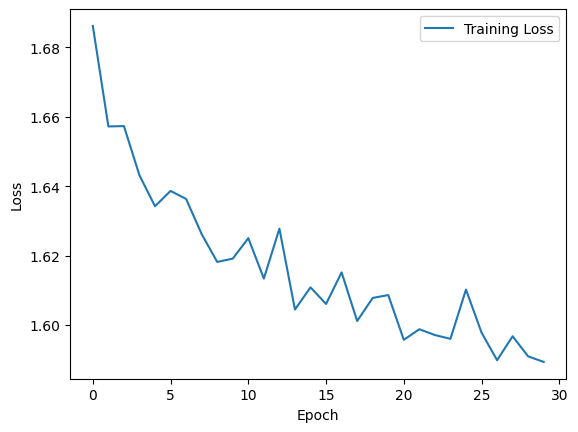

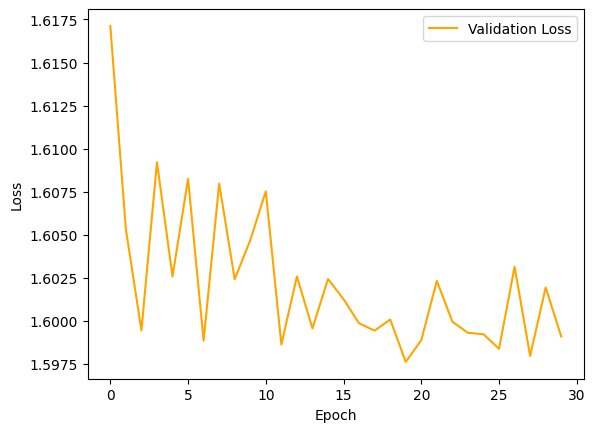

In [39]:
# plotting losses
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(val_losses, label='Validation Loss', color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### evaluation on test set

In [40]:
RNN_model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader:
        batch_X = batch_X.to(device)

        outputs, _ = RNN_model(batch_X)
        _, predicted = torch.max(outputs, 1)
        # actual now is not one hot encoding so:

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
RNN_Model_accuracy = accuracy_score(all_labels, all_preds)
RNN_Model_cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy on test data: {RNN_Model_accuracy * 100:.2f}%")
print("Confusion Matrix: ")
print(RNN_Model_cm)

Accuracy on test data: 23.38%
Confusion Matrix: 
[[  3   2 291  16   7]
 [  2   3 350  20  14]
 [  1   3 385   2   5]
 [  2   3 371  14   4]
 [  3   7 226  11   4]]


### 7- GRU
Make and train a Neural Network with GRU on tokenized train data and evaluate on test data.

In [41]:
class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, output_size = 5):
      super(GRU_Model, self).__init__()
      self.hidden_units = hidden_units
      self.dropout = nn.Dropout(0.5)
      # Arch
      self.embedding = nn.Embedding(vocab_size, embedding_dim)
      self.gru = nn.GRU(embedding_dim, hidden_units)
      self.fc = nn.Linear(hidden_units, output_size)
      self.bn = nn.BatchNorm1d(hidden_units)

    def initialize_hidden_state(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_units)

    def forward(self, x):
      x = self.embedding(x)
      x = self.dropout(x)
      x = x.permute(1, 0, 2)
      self.hidden = self.initialize_hidden_state(x.size(1)).to(x.device)
      out, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden units
      out = out[-1, :, :]
      out = self.bn(out)
      out = self.dropout(out)
      out = self.fc(out)
      return out, self.hidden


In [47]:
## sanity check
GRU_model = GRU_Model(vocab_size=len(constructed_vocab.word2idx), embedding_dim=128,hidden_units=100)
GRU_model.to(device)
GRU_model.eval()
output, hidden = GRU_model(batch_X.to(device))
output.shape, hidden.shape

(torch.Size([64, 5]), torch.Size([1, 64, 100]))

#### Training Loop

In [51]:
%%time
num_epochs = 50
lr = 1e-3
optimizer = torch.optim.Adam(GRU_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# training loop
train_losses = []
val_losses = []

for i in range(num_epochs):

  epoch_weighted_loss = 0
  # train loop
  GRU_model.train()
  for batch_X, batch_y in train_dataloader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    outputs, _ = GRU_model(batch_X)
    loss = criterion(outputs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    epoch_weighted_loss += (len(batch_y) * loss.item())


  epoch_loss = epoch_weighted_loss/len(train_dataloader.dataset)
  train_losses.append(epoch_loss)
  # validation
  GRU_model.eval()
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_dataloader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs, _ = GRU_model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

  val_epoch_loss = val_epoch_weighted_loss/len(val_dataloader.dataset)
  val_losses.append(val_epoch_loss)
  val_accuracy = correctly_labelled/len(val_dataloader.dataset)*100
  print(f'epoch {i+1}/{num_epochs}, training loss = {epoch_loss}, validation loss = {val_epoch_loss}, validation accuracy = {val_accuracy}')



epoch 1/50, training loss = 0.9197851496577604, validation loss = 1.4339045680521105, validation accuracy = 48.09885931558935
epoch 2/50, training loss = 0.8349160109101649, validation loss = 1.6756128326568314, validation accuracy = 46.57794676806083
epoch 3/50, training loss = 0.7968055533863725, validation loss = 1.5008245180768205, validation accuracy = 48.669201520912544
epoch 4/50, training loss = 0.7615125226929117, validation loss = 1.311206989415245, validation accuracy = 57.22433460076045
epoch 5/50, training loss = 0.6967145815335718, validation loss = 1.323776049758998, validation accuracy = 56.84410646387833
epoch 6/50, training loss = 0.6628548494982334, validation loss = 1.349828589098535, validation accuracy = 58.174904942965775
epoch 7/50, training loss = 0.6242853792137922, validation loss = 1.5837327763154934, validation accuracy = 53.99239543726235
epoch 8/50, training loss = 0.594358979011013, validation loss = 1.4152375101589885, validation accuracy = 57.224334600

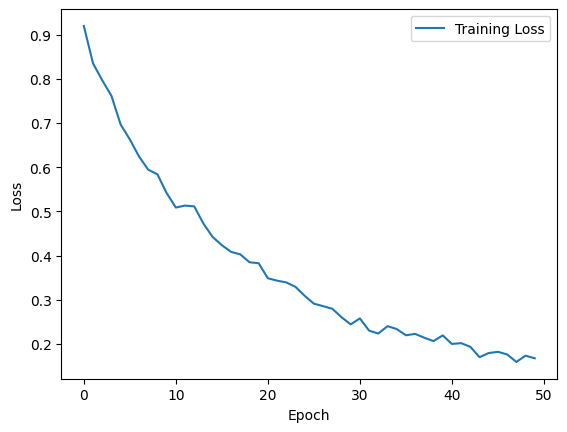

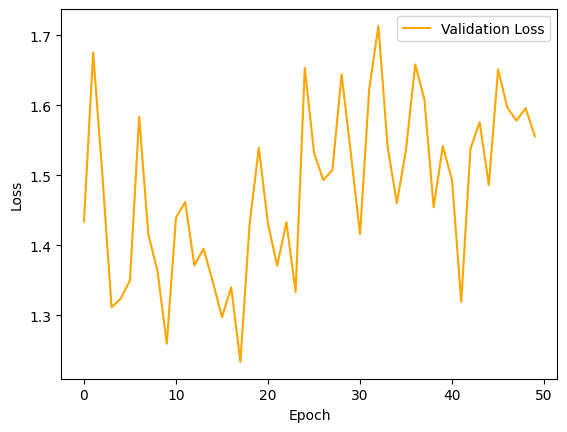

In [52]:
# plotting losses
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(val_losses, label='Validation Loss', color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### evaluation on test set

In [53]:
GRU_model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader:
        batch_X = batch_X.to(device)
        outputs, _ = GRU_model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

GRU_Model_accuracy = accuracy_score(all_labels, all_preds)
GRU_Model_cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy on test data: {GRU_Model_accuracy * 100:.2f}%")
print("Confusion Matrix: ")
print(GRU_Model_cm)

Accuracy on test data: 67.52%
Confusion Matrix: 
[[165  12  27  27  88]
 [  8 326  24  24   7]
 [ 15  19 308  31  23]
 [ 17  31  39 272  35]
 [ 85  10  24  22 110]]


### 8- LSTM
Make and train a Neural Network with LSTM on tokenized train data and evaluate on test data.

In [61]:
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, output_size = 5):
      super(LSTM_Model, self).__init__()
      self.hidden_units = hidden_units
      self.dropout = nn.Dropout(0.5)
      # Arch
      self.embedding = nn.Embedding(vocab_size, embedding_dim)
      self.lstm = nn.LSTM(embedding_dim, hidden_units)
      self.fc = nn.Linear(hidden_units, output_size)
      self.bn = nn.BatchNorm1d(hidden_units)

    def initialize_hidden_state(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_units)

    def forward(self, x):
      x = self.embedding(x)
      x = self.dropout(x)
      x = x.permute(1, 0, 2)
      self.hidden = self.initialize_hidden_state(x.size(1)).to(x.device)
      self.cell_state = self.initialize_hidden_state(x.size(1)).to(x.device)

      out, (self.hidden, self.cell_state) = self.lstm(x, (self.hidden, self.cell_state))  # max_len X batch_size X hidden units
      out = out[-1, :, :]
      out = self.bn(out)
      out = self.dropout(out)
      out = self.fc(out)
      return out, self.hidden


In [65]:
## sanity check
LSTM_model = LSTM_Model(vocab_size=len(constructed_vocab.word2idx), embedding_dim=128, hidden_units=100)
LSTM_model.to(device)
LSTM_model.eval()
output, hidden = LSTM_model(batch_X.to(device))
output.shape, hidden.shape

(torch.Size([54, 5]), torch.Size([1, 54, 100]))

#### Training Loop

In [66]:
%%time
num_epochs = 50
lr = 1e-3
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# training loop
train_losses = []
val_losses = []

for i in range(num_epochs):

  epoch_weighted_loss = 0
  # train loop
  LSTM_model.train()
  for batch_X, batch_y in train_dataloader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    outputs, _ = LSTM_model(batch_X)
    loss = criterion(outputs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    epoch_weighted_loss += (len(batch_y) * loss.item())


  epoch_loss = epoch_weighted_loss/len(train_dataloader.dataset)
  train_losses.append(epoch_loss)
  # validation
  LSTM_model.eval()
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_dataloader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs, _ = LSTM_model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

  val_epoch_loss = val_epoch_weighted_loss/len(val_dataloader.dataset)
  val_losses.append(val_epoch_loss)
  val_accuracy = correctly_labelled/len(val_dataloader.dataset)*100
  print(f'epoch {i+1}/{num_epochs}, training loss = {epoch_loss}, validation loss = {val_epoch_loss}, validation accuracy = {val_accuracy}')



epoch 1/50, training loss = 1.785054744254057, validation loss = 1.632913168392254, validation accuracy = 21.482889733840306
epoch 2/50, training loss = 1.7340837287176913, validation loss = 1.605187666280188, validation accuracy = 21.292775665399237
epoch 3/50, training loss = 1.6641495633873908, validation loss = 1.6169362775273197, validation accuracy = 20.722433460076044
epoch 4/50, training loss = 1.6628399314934814, validation loss = 1.6024807881946346, validation accuracy = 21.292775665399237
epoch 5/50, training loss = 1.6286126068951854, validation loss = 1.5965718089854308, validation accuracy = 24.14448669201521
epoch 6/50, training loss = 1.6127922528137149, validation loss = 1.5912253521241162, validation accuracy = 21.673003802281368
epoch 7/50, training loss = 1.5992390879214546, validation loss = 1.5903047382151672, validation accuracy = 24.524714828897338
epoch 8/50, training loss = 1.5866574529916417, validation loss = 1.600742615221118, validation accuracy = 21.29277

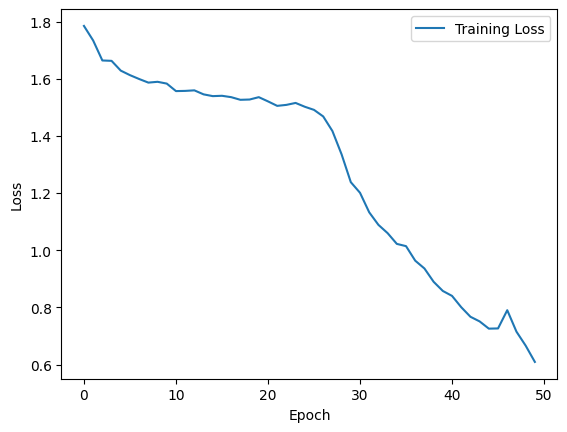

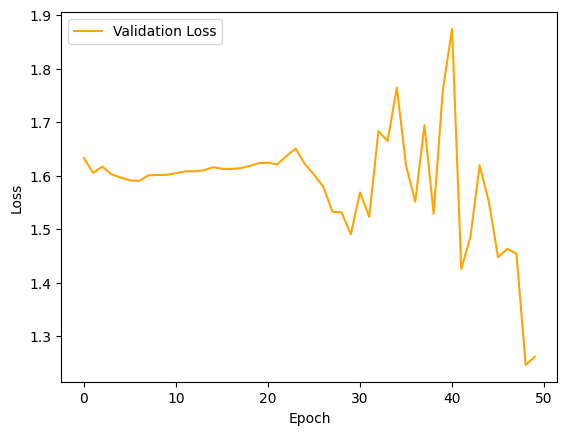

In [67]:
# plotting losses
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(val_losses, label='Validation Loss', color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### evaluation on test set

In [68]:
LSTM_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader:
        batch_X = batch_X.to(device)
        outputs, _ = LSTM_model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

LSTM_model_accuracy = accuracy_score(all_labels, all_preds)
LSTM_model_cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy on test data: {LSTM_model_accuracy * 100:.2f}%")
print("Confusion Matrix: ")
print(LSTM_model_cm)

Accuracy on test data: 58.38%
Confusion Matrix: 
[[218   2  34  36  29]
 [ 20 236  97  32   4]
 [ 25  14 311  44   2]
 [ 69   8  81 227   9]
 [152   3  36  31  29]]


### 9- Performance benchmark
Lastly, report the performance of each model by using confusion matrices.

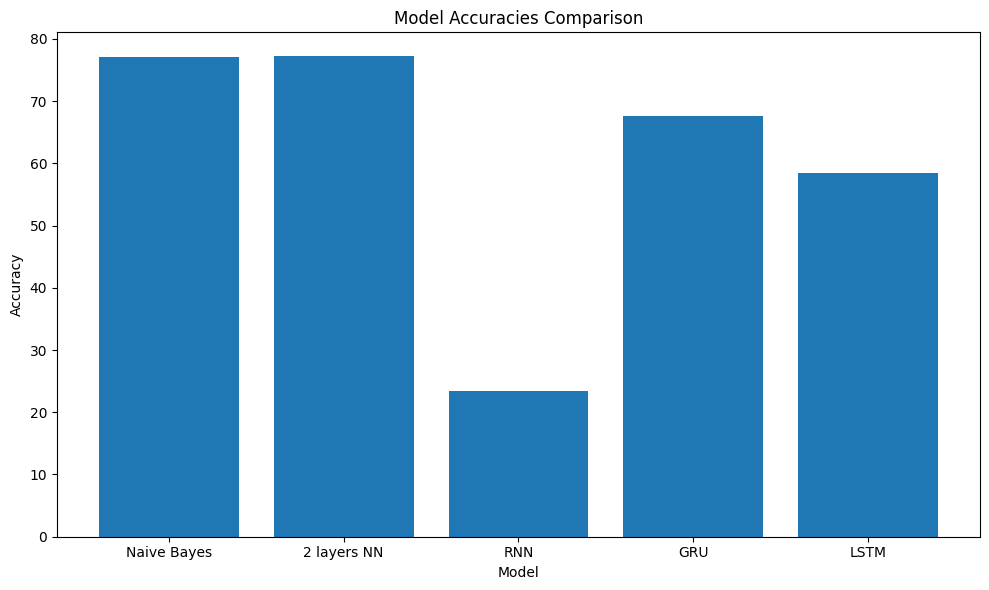

In [69]:
# plot accurcy of each model
models = ['Naive Bayes', '2 layers NN', 'RNN', 'GRU', 'LSTM']
accuracies = [NaiveBayesModel_accuracy, NN_Model_accuracy, RNN_Model_accuracy, GRU_Model_accuracy, LSTM_model_accuracy]
plt.figure(figsize=(10, 6))
plt.bar(models, [accuracy * 100 for accuracy in accuracies])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies Comparison')
plt.tight_layout()
plt.show()

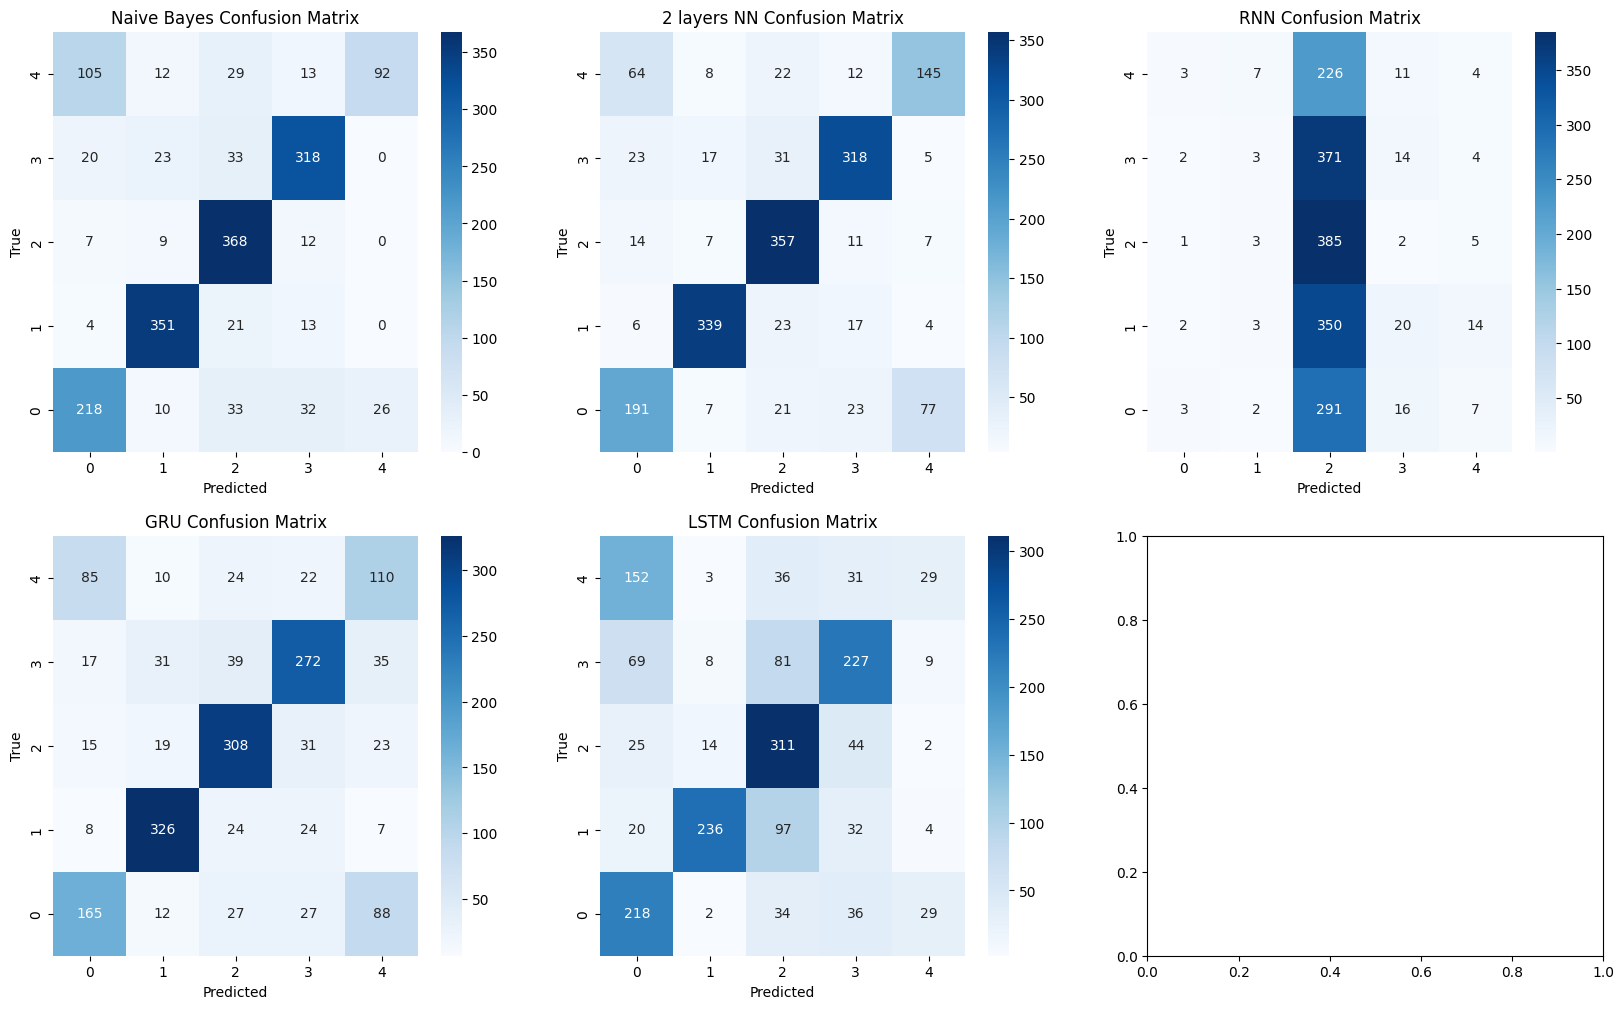

In [70]:
confusion_matrices = [NaiveBayesModel_cm, NN_Model_cm, RNN_Model_cm, GRU_Model_cm, LSTM_model_cm]
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, (model, cm) in enumerate(zip(models, confusion_matrices)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].invert_yaxis()

plt.show()